<a href="https://colab.research.google.com/github/AbrarAli-SE/Code-a-Ai/blob/main/CACD_Ai_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -----------------------------------------------------------------
# CELL 1: Imports and Environment Setup
# -----------------------------------------------------------------
import os
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns # Crucial for nice Confusion Matrices and heatmaps

# Configure GPU memory growth (prevents some Colab crashes)
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"✅ GPU Detected: {len(gpus)} available")
except RuntimeError as e:
    print(e)

print("✅ Libraries imported successfully.")

✅ GPU Detected: 1 available
✅ Libraries imported successfully.


In [ ]:
# -----------------------------------------------------------------
# CELL 2: Download and Unzip CACD Dataset
# -----------------------------------------------------------------
from google.colab import files

# 1. Upload Kaggle API Key
if not os.path.exists('kaggle.json'):
    print("Please upload your 'kaggle.json' file:")
    files.upload()

# 2. Setup Kaggle Config
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download the CACD Dataset (Filtered version)
# We use the 'pdombrza/cacd-filtered-dataset' which is cleaner than raw CACD
print("\n⬇️ Downloading CACD Dataset... (This may take 2-4 minutes)")
if not os.path.exists('cacd-filtered-dataset.zip'):
    !kaggle datasets download -d pdombrza/cacd-filtered-dataset
else:
    print("Dataset zip already exists.")

# 4. Unzip
print("📦 Unzipping images... (This takes time due to 160k+ files)")
if not os.path.exists('cacd_data'):
    with zipfile.ZipFile('cacd-filtered-dataset.zip', 'r') as zip_ref:
        zip_ref.extractall('cacd_data')
    print("✅ Unzip Complete.")

# 5. Quick Verification
# Check if the CSV and image folder exist
csv_path = 'cacd_data/cacd_train.csv' # Common name, we will verify in next step
print(f"\n📂 Files in dataset folder: {os.listdir('cacd_data')}")

Please upload your 'kaggle.json' file:


Saving kaggle.json to kaggle.json

⬇️ Downloading CACD Dataset... (This may take 2-4 minutes)
Dataset URL: https://www.kaggle.com/datasets/pdombrza/cacd-filtered-dataset
License(s): unknown
 99% 3.34G/3.36G [00:38<00:00, 224MB/s]
100% 3.36G/3.36G [00:38<00:00, 93.7MB/s]
📦 Unzipping images... (This takes time due to 160k+ files)
✅ Unzip Complete.

📂 Files in dataset folder: ['CACD_features_sex.csv', 'cacd_split']


In [ ]:
# -----------------------------------------------------------------
# CELL 3: Data Preparation (Cleaned)
# -----------------------------------------------------------------
import pandas as pd
import os
from sklearn.model_selection import train_test_split

print("🔄 Processing metadata...")

base_dir = 'cacd_data'
csv_filename = 'CACD_features_sex.csv'

# 1. Build File Map (Robust Method)
# We scan the directory once to link filenames to their exact path
file_to_path_map = {}
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith('.jpg'):
            file_to_path_map[file] = os.path.join(root, file)

# 2. Load CSV
# Find the CSV file automatically
csv_path = os.path.join(base_dir, csv_filename)
for root, dirs, files in os.walk(base_dir):
    if csv_filename in files:
        csv_path = os.path.join(root, csv_filename)
        break

df = pd.read_csv(csv_path)

# 3. Clean & Map Data
# Normalize column names
if 'name' in df.columns: df.rename(columns={'name': 'filename'}, inplace=True)
if 'Age' in df.columns: df.rename(columns={'Age': 'age'}, inplace=True)

# Map filenames to the paths we found in step 1
df['filepath'] = df['filename'].map(file_to_path_map)

# Filter valid rows (must have a file found and a valid age)
df = df.dropna(subset=['filepath', 'age'])
df['age'] = pd.to_numeric(df['age'], errors='coerce')
df = df[(df['age'] > 0) & (df['age'] < 120)]

# 4. Split Data (90/10 split)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

print(f"✅ Data Ready.")
print(f"   Training Images: {len(train_df)}")
print(f"   Testing Images:  {len(test_df)}")

🔄 Processing metadata...
✅ Data Ready.
   Training Images: 139423
   Testing Images:  15492


In [ ]:
# -----------------------------------------------------------------
# CELL 4: Image Generators
# -----------------------------------------------------------------
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Constants
BATCH_SIZE = 64  # Increased to 64 for speed (CACD images are small usually)
IMG_SIZE = 128   # Resize all images to 128x128
TARGET_SIZE = (IMG_SIZE, IMG_SIZE)

print("⚙️ configuring Data Generators...")

# 1. Training Generator (With Augmentation)
# We add variety to the training data to prevent memorization
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values (0-1)
    horizontal_flip=True,       # Mirror images (left/right)
    rotation_range=10,          # Slight rotations
    width_shift_range=0.1,      # Shift left/right
    height_shift_range=0.1,     # Shift up/down
    brightness_range=[0.8, 1.2] # Vary brightness
)

# 2. Testing Generator (No Augmentation - Pure Validation)
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Flow Data
print("🌊 Creating Data Flow...")
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='age',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw', # 'raw' is required for Regression (predicting numbers)
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='age',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)

print("✅ Generators Ready.")

⚙️ configuring Data Generators...
🌊 Creating Data Flow...
Found 139423 validated image filenames.
Found 15492 validated image filenames.
✅ Generators Ready.


In [ ]:
# -----------------------------------------------------------------
# CELL 5: Custom ResNet Architecture
# -----------------------------------------------------------------
import tensorflow as tf
from tensorflow.keras import layers, models, Input

print("🏗️ Building Custom ResNet Model...")

def residual_block(x, filters, stride=1):
    """
    A Residual Block with Skip Connections.
    Allows the model to learn 'residuals' (differences) which helps with depth.
    """
    shortcut = x

    # First Convolution
    x = layers.Conv2D(filters, (3, 3), strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second Convolution
    x = layers.Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if dimensions change
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # The Magic: Add the shortcut to the output
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# --- Main Architecture ---
inputs = Input(shape=(128, 128, 3))

# Entry Block
x = layers.Conv2D(32, (3, 3), padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

# Stacking Residual Blocks (Deepening the network)
x = residual_block(x, 32, stride=1)
x = residual_block(x, 64, stride=2)  # 64x64
x = residual_block(x, 64, stride=1)
x = residual_block(x, 128, stride=2) # 32x32
x = residual_block(x, 128, stride=1)
x = residual_block(x, 256, stride=2) # 16x16
x = residual_block(x, 256, stride=1)
x = residual_block(x, 512, stride=2) # 8x8

# Output Head (RAM Efficient)
x = layers.GlobalAveragePooling2D()(x) # Converts 8x8x512 -> 512 vector
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

# Final Regression Neuron (Linear activation for Age)
outputs = layers.Dense(1, activation='linear')(x)

model = models.Model(inputs=inputs, outputs=outputs)

# Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error', # MAE is best for age (interpretable)
    metrics=['mean_absolute_error']
)

model.summary()
print("✅ Model Built and Compiled.")

🏗️ Building Custom ResNet Model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      9,248 │ activation_1[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ add[0][0]         │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     18,496 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     36,928 │ activation_3[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │      2,112 │ activation_2[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]  

 Total params: 6,592,769 (25.15 MB)

 Trainable params: 6,585,025 (25.12 MB)

 Non-trainable params: 7,744 (30.25 KB)

✅ Model Built and Compiled.


In [ ]:
# -----------------------------------------------------------------
# CELL FIX: Run this ONCE to stop the "Truncated Image" crash
# -----------------------------------------------------------------
from PIL import ImageFile

# This tells Python: "If an image is broken, just load what you can."
ImageFile.LOAD_TRUNCATED_IMAGES = True

print("✅ Fixed: The model will now ignore broken images and keep training.")

✅ Fixed: The model will now ignore broken images and keep training.


In [ ]:
# -----------------------------------------------------------------
# CELL 6: Training
# -----------------------------------------------------------------
print("🚀 Starting Training... (This will take 1.5 - 2+ hours)")

# Callbacks
callbacks = [
    # Stop if validation doesn't improve for 8 epochs
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate if we get stuck
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1
    )
]

# Calculate steps
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(test_df) // BATCH_SIZE

history = model.fit(
    train_generator,
    epochs=40, # High epoch count, EarlyStopping will handle the rest
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Save the final model
model.save('cacd_age_model_final.h5')
print("✅ Training Complete. Model saved as 'cacd_age_model_final.h5'")


🚀 Starting Training... (This will take 1.5 - 2+ hours)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 1050s 465ms/step - loss: 10.3704 - mean_absolute_error: 10.3704 - val_loss: 9.9470 - val_mean_absolute_error: 9.9470 - learning_rate: 0.0010
Epoch 2/40
   1/2178 ━━━━━━━━━━━━━━━━━━━━ 9:01 249ms/step - loss: 9.1637 - mean_absolute_error: 9.1637

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2178/2178 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 9.1637 - mean_absolute_error: 9.1637 - val_loss: 10.0390 - val_mean_absolute_error: 10.0390 - learning_rate: 0.0010
Epoch 3/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 920s 422ms/step - loss: 9.3769 - mean_absolute_error: 9.3769 - val_loss: 9.1648 - val_mean_absolute_error: 9.1648 - learning_rate: 0.0010
Epoch 4/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 10.7065 - mean_absolute_error: 10.7065 - val_loss: 8.9162 - val_mean_absolute_error: 8.9162 - learning_rate: 0.0010
Epoch 5/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 908s 417ms/step - loss: 8.4541 - mean_absolute_error: 8.4541 - val_loss: 7.8161 - val_mean_absolute_error: 7.8161 - learning_rate: 0.0010
Epoch 6/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 8.5565 - mean_absolute_error: 8.5565 - val_loss: 7.8677 - val_mean_absolute_error: 7.8677 - learning_rate: 0.0010
Epoch 7/40
2178/2178 ━━━━━━━━━━━━━━━━━━━━ 920s 423ms/step - loss: 7.7625 - mean_absolute_error: 7.7625 - val_loss: 9

KeyboardInterrupt: 

In [ ]:
# ==========================================
# EMERGENCY SAVE SCRIPT
# Run this immediately after pressing "Stop" on the training cell
# ==========================================
import os

print("🛑 Training Interrupted safely.")
print("💾 Saving the current model state...")

# Save the model currently in memory
model.save('cacd_age_model_emergency.h5')

print("✅ Model saved as 'cacd_age_model_emergency.h5'")

# --- Download Trigger ---
from google.colab import files
try:
    print("⬇️ Starting download to your computer...")
    files.download('cacd_age_model_emergency.h5')
except ImportError:
    # If using Kaggle
    from IPython.display import FileLink
    print("🔗 Click below to download:")
    display(FileLink('cacd_age_model_emergency.h5'))

🛑 Training Interrupted safely.
💾 Saving the current model state...
✅ Model saved as 'cacd_age_model_emergency.h5'
⬇️ Starting download to your computer...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📊 EVALUATING AGE MODEL & GENERATING REPORT ASSETS

📂 Loading best saved model...
⚠️ Could not load from disk, using model currently in memory.

🔮 Generating Predictions...
243/243 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step
📸 Saving Scatter Plot...


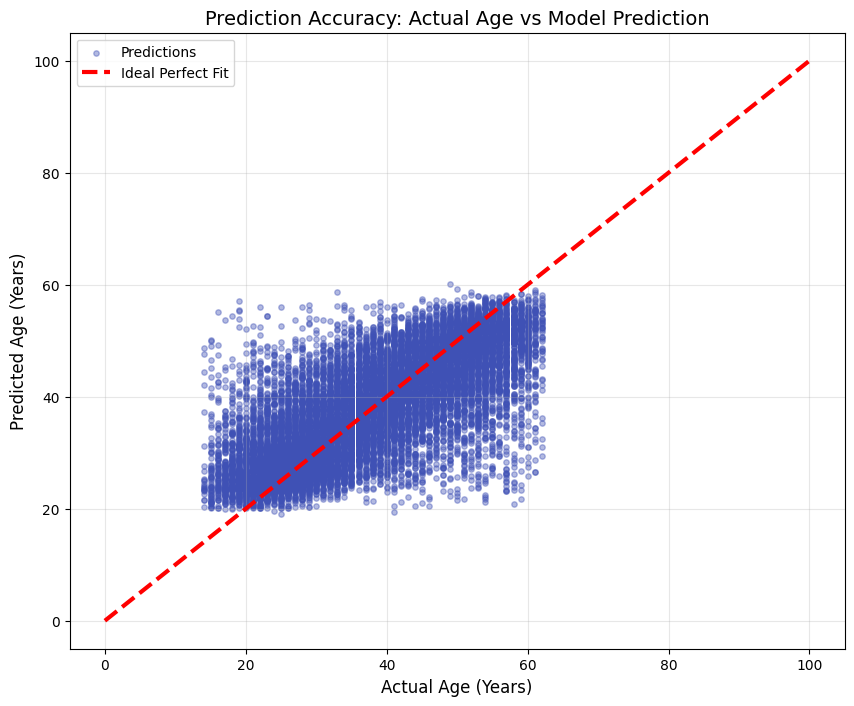

📸 Saving Error Histogram...


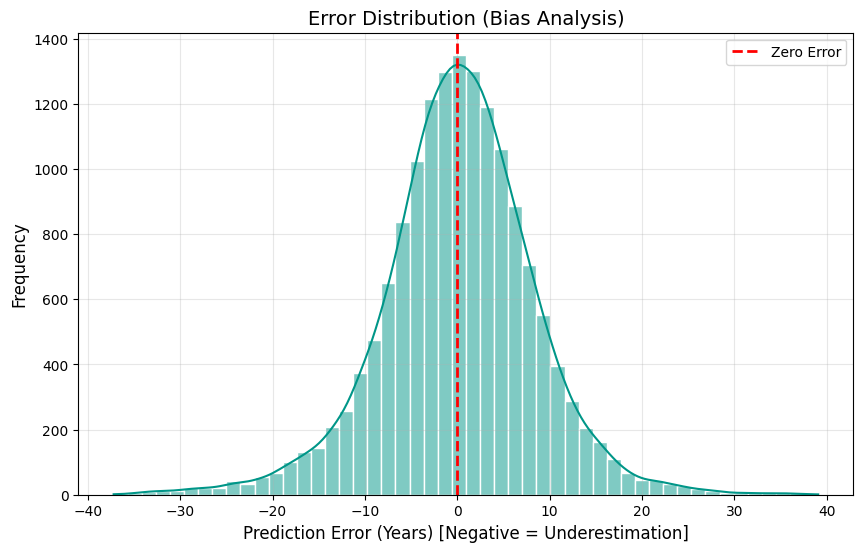

📸 Saving Confusion Matrix...


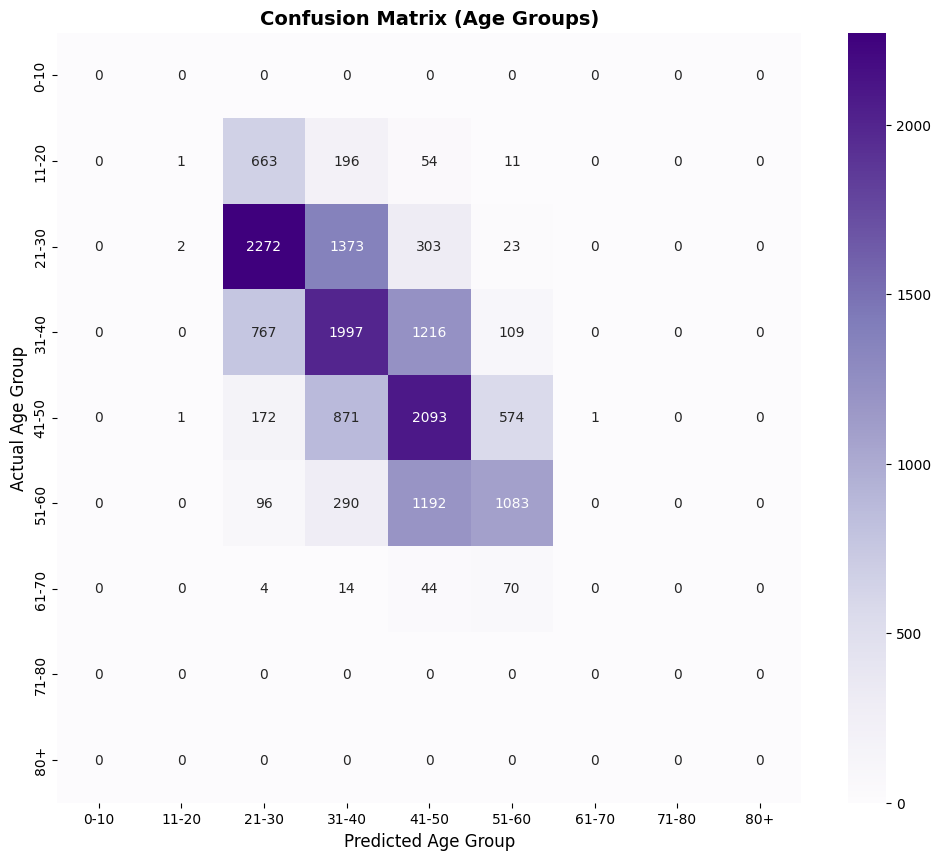

📸 Generatng Detailed Table Image...


/tmp/ipython-input-738892382.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = df_analysis.groupby('Age Group')['Error'].agg(['mean', 'count', 'std']).reset_index()


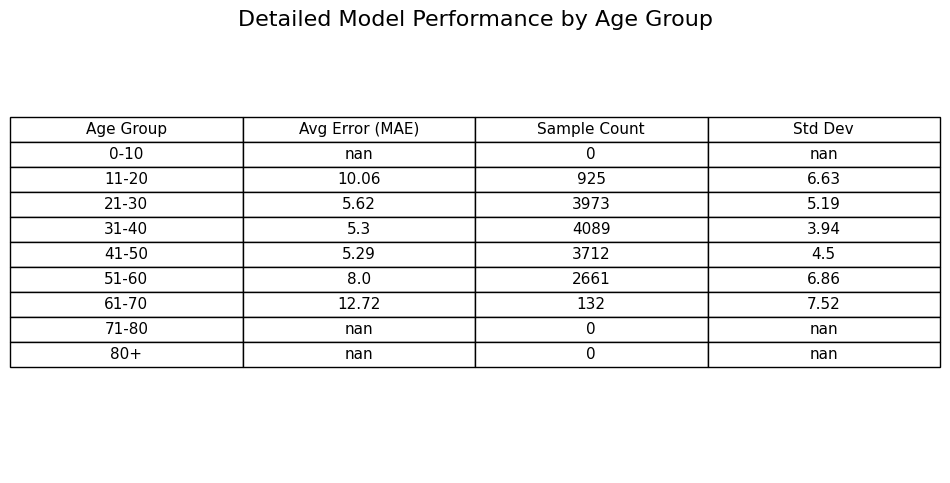

📸 Saving Final Report Card...


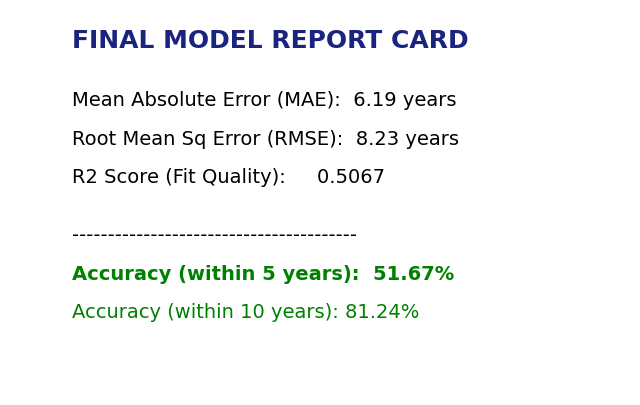


✅ All images generated!
📦 Created 'Report_Images.zip'. Download this file for your report.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# -----------------------------------------------------------------
# CELL 7: Detailed Age Prediction Analysis & Report Generation
# -----------------------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error
from tensorflow.keras.models import load_model

# Create a folder for report images
output_dir = 'report_assets'
os.makedirs(output_dir, exist_ok=True)

print("=" * 60)
print("📊 EVALUATING AGE MODEL & GENERATING REPORT ASSETS")
print("=" * 60)

# ============================================
# 1. Load Best Model
# ============================================
print("\n📂 Loading best saved model...")
model_files = ['cacd_age_model_lite.h5', 'cacd_age_model_final.h5']
best_model = None

for mf in model_files:
    try:
        best_model = load_model(mf)
        print(f"✅ Loaded: {mf}")
        break
    except:
        continue

if best_model is None:
    print("⚠️ Could not load from disk, using model currently in memory.")
    best_model = model

# ============================================
# 2. Generate Predictions
# ============================================
print("\n🔮 Generating Predictions...")
test_generator.reset()
predictions = best_model.predict(test_generator, verbose=1)
y_pred = predictions.flatten()
y_true = test_generator.labels

# Calculate Errors
errors = y_pred - y_true
abs_errors = np.abs(errors)

# ============================================
# 3. GRAPH 1: Scatter Plot (Actual vs Predicted)
# ============================================
print("📸 Saving Scatter Plot...")
plt.figure(figsize=(10, 8))
plt.scatter(y_true, y_pred, alpha=0.4, s=15, color='#3F51B5', label='Predictions')
plt.plot([0, 100], [0, 100], 'r--', linewidth=3, label='Ideal Perfect Fit')
plt.title('Prediction Accuracy: Actual Age vs Model Prediction', fontsize=14)
plt.xlabel('Actual Age (Years)', fontsize=12)
plt.ylabel('Predicted Age (Years)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_dir}/1_Scatter_Plot.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 4. GRAPH 2: Error Distribution
# ============================================
print("📸 Saving Error Histogram...")
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True, color='#009688', edgecolor='white')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Error Distribution (Bias Analysis)', fontsize=14)
plt.xlabel('Prediction Error (Years) [Negative = Underestimation]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(f"{output_dir}/2_Error_Distribution.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 5. GRAPH 3: Confusion Matrix
# ============================================
print("📸 Saving Confusion Matrix...")
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 120]
labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '80+']

y_pred_binned = pd.cut(y_pred, bins=bins, labels=labels)
y_true_binned = pd.cut(y_true, bins=bins, labels=labels)

cm = confusion_matrix(y_true_binned, y_pred_binned, labels=labels)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Age Groups)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Age Group', fontsize=12)
plt.ylabel('Actual Age Group', fontsize=12)
plt.savefig(f"{output_dir}/3_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 6. TABLE IMAGE: Detailed Age Group Performance
# ============================================
print("📸 Generatng Detailed Table Image...")

# Create DataFrame for Analysis
df_analysis = pd.DataFrame({'True': y_true, 'Pred': y_pred, 'Error': abs_errors})
df_analysis['Age Group'] = pd.cut(df_analysis['True'], bins=bins, labels=labels)
group_stats = df_analysis.groupby('Age Group')['Error'].agg(['mean', 'count', 'std']).reset_index()
group_stats.columns = ['Age Group', 'Avg Error (MAE)', 'Sample Count', 'Std Dev']
group_stats['Avg Error (MAE)'] = group_stats['Avg Error (MAE)'].round(2)
group_stats['Std Dev'] = group_stats['Std Dev'].round(2)

# Render as Image
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=group_stats.values, colLabels=group_stats.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5) # Scale table size
plt.title("Detailed Model Performance by Age Group", fontsize=16, y=0.95)
plt.savefig(f"{output_dir}/4_Detailed_Performance_Table.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 7. SCORECARD IMAGE: Final Metrics
# ============================================
print("📸 Saving Final Report Card...")

mae = np.mean(abs_errors)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
acc_5 = np.mean(abs_errors <= 5) * 100
acc_10 = np.mean(abs_errors <= 10) * 100

# Create a text-based image for the report summary
plt.figure(figsize=(8, 5))
plt.text(0.1, 0.9, "FINAL MODEL REPORT CARD", fontsize=18, fontweight='bold', color='#1A237E')
plt.text(0.1, 0.75, f"Mean Absolute Error (MAE):  {mae:.2f} years", fontsize=14)
plt.text(0.1, 0.65, f"Root Mean Sq Error (RMSE):  {rmse:.2f} years", fontsize=14)
plt.text(0.1, 0.55, f"R2 Score (Fit Quality):     {r2:.4f}", fontsize=14)
plt.text(0.1, 0.40, "-"*40, fontsize=14)
plt.text(0.1, 0.30, f"Accuracy (within 5 years):  {acc_5:.2f}%", fontsize=14, color='green', fontweight='bold')
plt.text(0.1, 0.20, f"Accuracy (within 10 years): {acc_10:.2f}%", fontsize=14, color='green')

plt.axis('off')
plt.savefig(f"{output_dir}/5_Final_Report_Card.png", dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# 8. Zip and Download
# ============================================
import shutil
shutil.make_archive('Report_Images', 'zip', output_dir)
print("\n✅ All images generated!")
print("📦 Created 'Report_Images.zip'. Download this file for your report.")

from google.colab import files
try:
    files.download('Report_Images.zip')
except:
    print("⚠️ Auto-download failed. Please check the file browser on the left.")